In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [5]:
plt.style.use('dark_background')

img = cv2.imread("image3.png")
img.shape

(3456, 5184, 3)

In [6]:
def show_imgs_jet(i1,i2,i3):
    fig=plt.figure(figsize=(25,10))
    ax = fig.add_subplot(131)
    plt.imshow(i1, cmap='jet')
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax = fig.add_subplot(132)
    plt.imshow(i2, cmap='jet')
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax = fig.add_subplot(133)
    plt.imshow(i3, cmap='jet')
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)

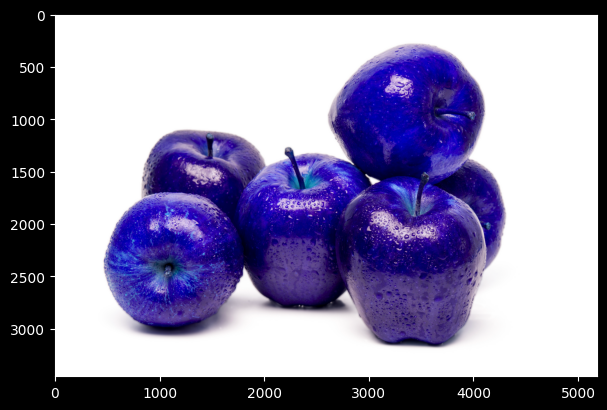

In [7]:
rgb_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

img_gray = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(7,7))
plt.imshow(img);

автоматически определенное оптимальное значение разделения
158.0


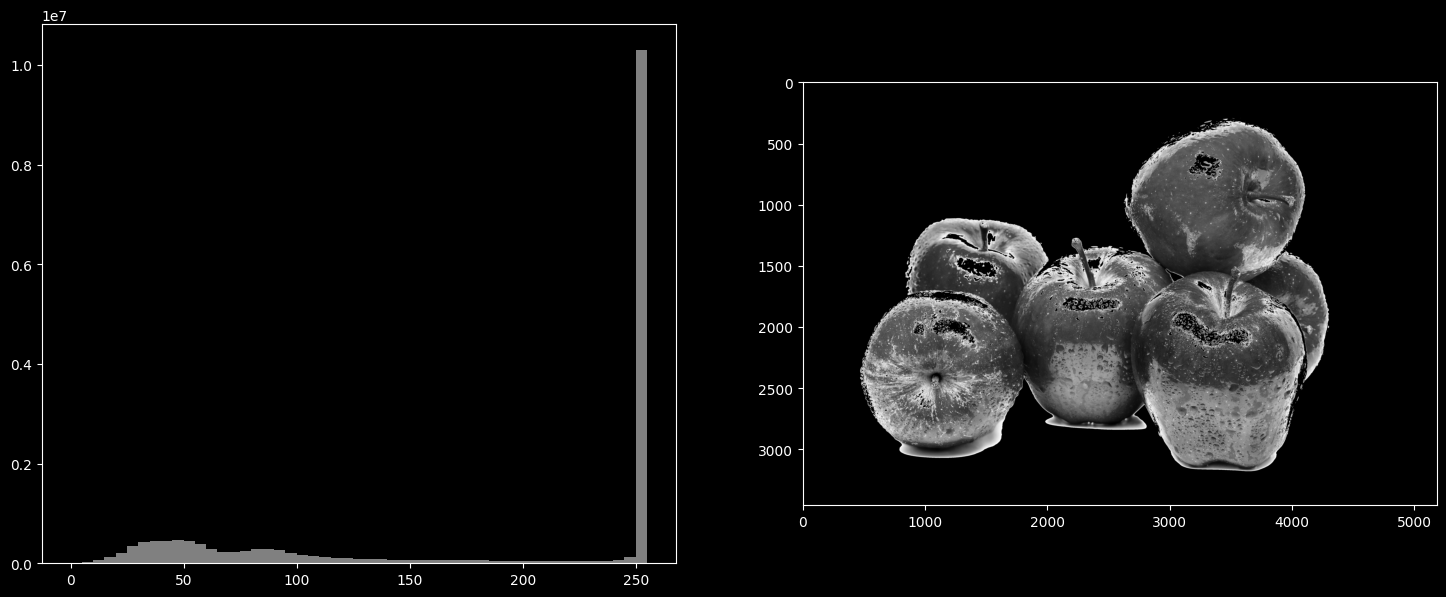

In [8]:
method = cv2.THRESH_TOZERO_INV # ["cv2.THRESH_BINARY" , "cv2.THRESH_BINARY_INV", "cv2.THRESH_TRUNC", "cv2.THRESH_TOZERO", "cv2.THRESH_TOZERO_INV" ]

image = img_gray

### метод Otsu
min_threshold = 0
max_threshold = 255
bins = 51      # количество разбиений
rg = (0,255)   # интересующий нас диапазон значений для разбиений
auto_detected_threshold,otsu_threshold = cv2.threshold(image,min_threshold,max_threshold,method+cv2.THRESH_OTSU)
# автоматически определенное оптимальное значение разделения
print('автоматически определенное оптимальное значение разделения')
print (auto_detected_threshold)


plt.figure(figsize=(18,7))
plt.subplot(121)
plt.hist(image.flatten(), bins, rg, color='gray')
plt.subplot(122)
plt.imshow(otsu_threshold,'gray');

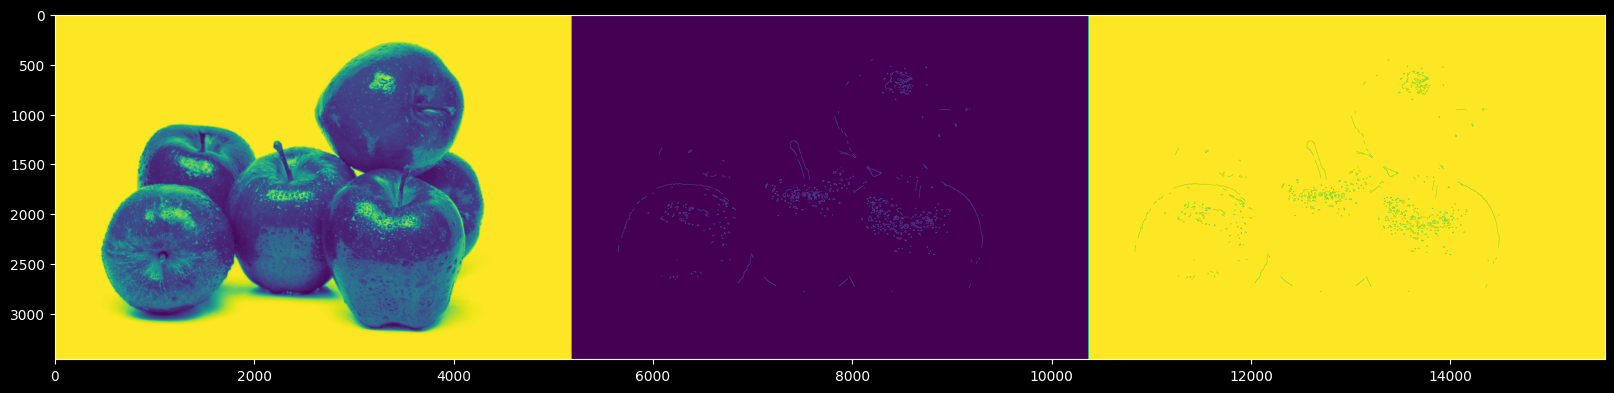

In [13]:
treshhold_down = 80 # min:0, max:255
treshhold_up = 152 # min:0, max:255
kernel_size = 15 # min:3, max:25

img_blur = cv2.GaussianBlur(img_gray,(kernel_size,kernel_size),0)

edges_Canny = cv2.Canny(img_blur, treshhold_down, treshhold_up)

_,edges_otsu_threshold = cv2.threshold(edges_Canny,min_threshold,max_threshold,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

images = np.hstack((img_blur, edges_Canny, edges_otsu_threshold))

plt.figure(figsize=(20,10))
plt.imshow(images);

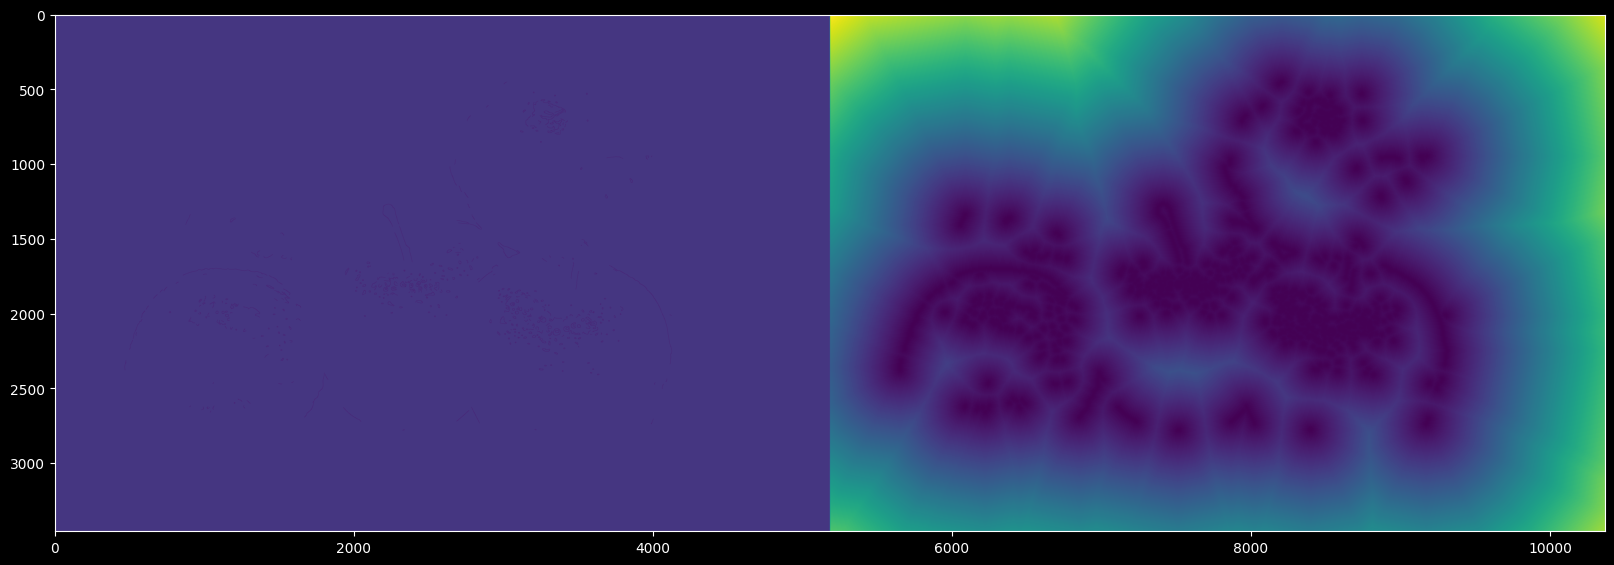

In [14]:
distanceType=cv2.DIST_L2 # ["cv2.DIST_C", "cv2.DIST_L1", "cv2.DIST_L2" ]
image = edges_otsu_threshold # ["otsu_threshold", "edges_otsu_threshold" ]

Dist_Transform = cv2.distanceTransform(image, distanceType=distanceType, maskSize=5)

images = np.hstack((image,Dist_Transform))

plt.figure(figsize=(20,10))
plt.imshow(images);

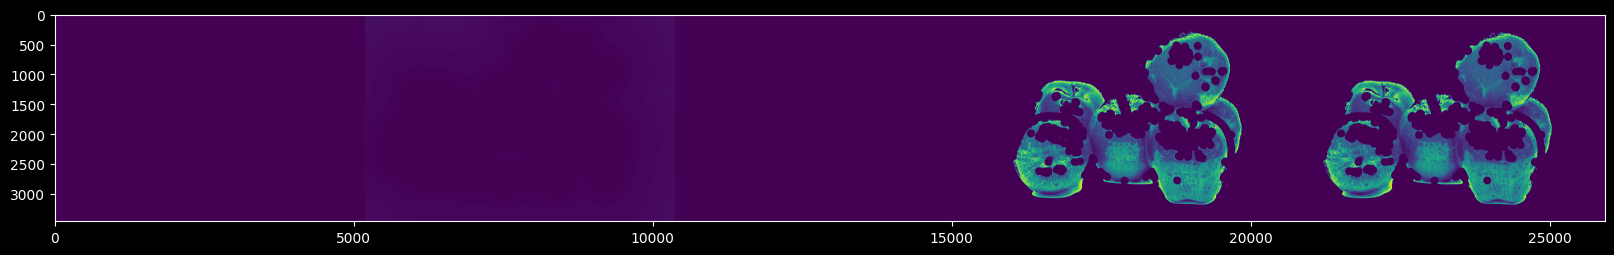

In [16]:
# Маска "фон"/ "не фон"
_, mask = cv2.threshold(img_gray,min_threshold,max_threshold,cv2.THRESH_TOZERO_INV+cv2.THRESH_OTSU)
_, mask_bin = cv2.threshold(img_gray,min_threshold,max_threshold,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
# Бинаризация результата Distance Transform
_, dist = cv2.threshold(Dist_Transform,0.25*255,255, cv2.THRESH_BINARY)

kernel = np.ones((4,4),np.uint8) # ядро
# "Прореживаем" результат умножения маски на бинаризацию Distance Transform
Dist_Transform_opening = cv2.morphologyEx(mask*dist, cv2.MORPH_OPEN, kernel)

images = np.hstack((mask,Dist_Transform,dist, mask*dist,Dist_Transform_opening))
# Итого визуализируем: Изображение и фон; Distance Transform; Бинаризацию Distance Transform
# умножение маски на бинаризацию Distance Transform и "почищенный" результат умножения

plt.figure(figsize=(20,10))
plt.imshow(images);

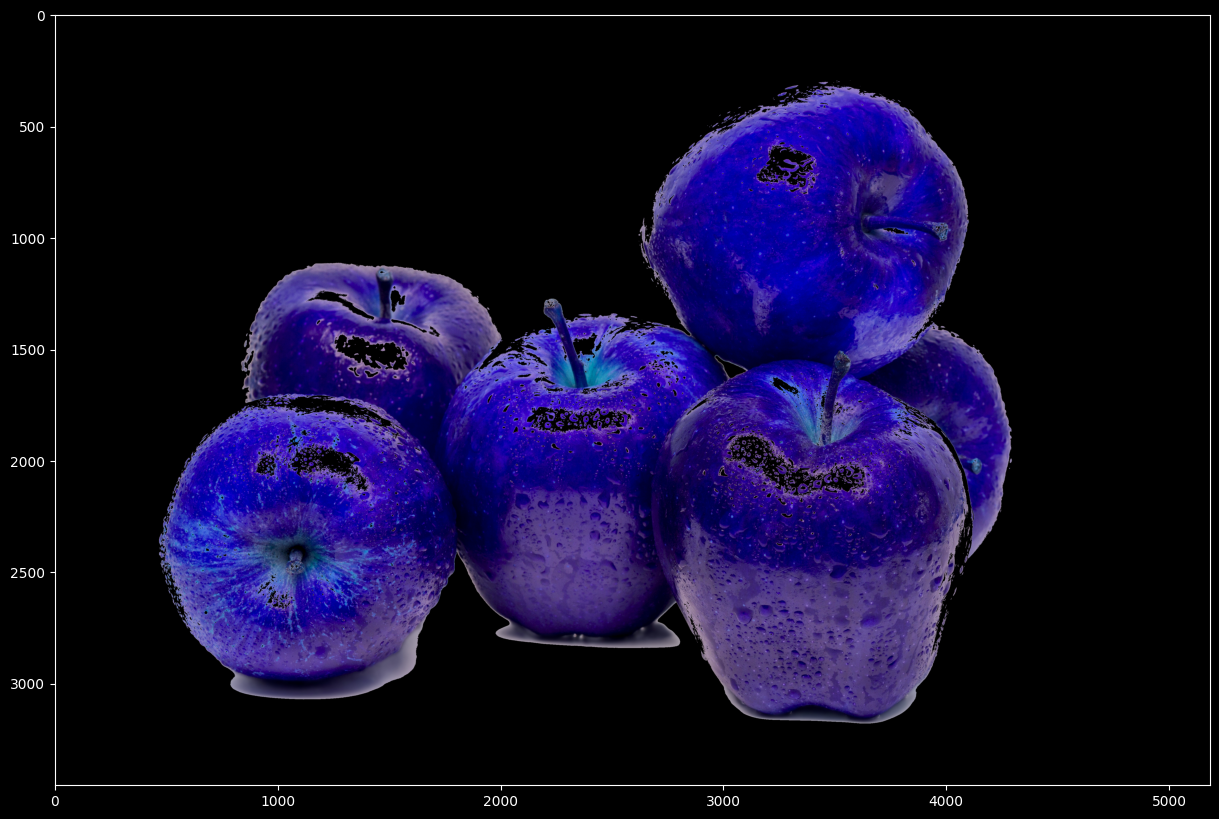

In [19]:
# Делаем изображение в котором уже нашли фон
img_copy = np.copy(img)
for c in range(3):
    img_copy[:,:,c]=img_copy[:,:,c]*(mask_bin/255).astype('uint8')

plt.figure(figsize=(20,10))
plt.imshow(img_copy);

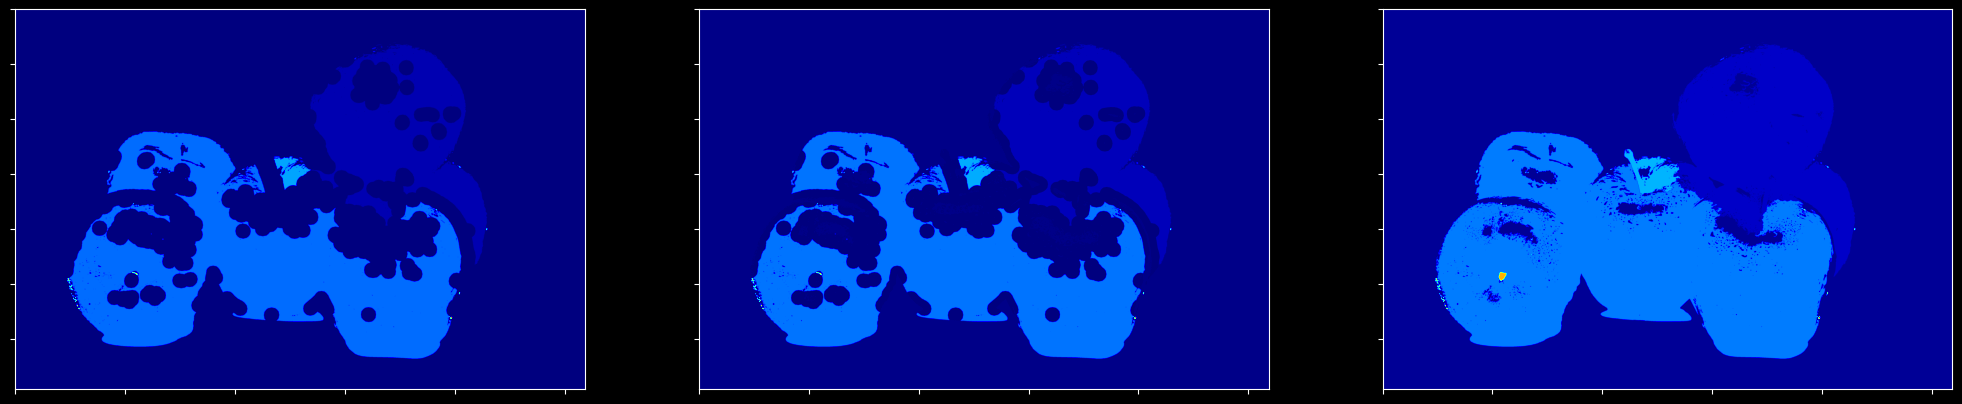

In [20]:
# Связанные Компоненты. "0" - весь фон, остальные цифры - разные связные компоненты
ret, markers = cv2.connectedComponents(Dist_Transform_opening.astype('uint8'))
# Делаем так, что метка "фона" - 1
markers = markers+1
# Делаем так, чтобы "неизвестные" регионы были равны "0"
_, mask = cv2.threshold(img_gray,min_threshold,max_threshold,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
unknown=cv2.subtract(mask,Dist_Transform_opening.astype('uint8'))
markers_unknown=np.copy(markers)
markers_unknown[unknown==255] = 0
markers_=np.copy(markers_unknown)
#Ищем не в исходном изображении, а там, где уже есть фон
image_for_seg=img_copy
markers_=cv2.watershed(image_for_seg,markers_)
# Итого визуализируем: исходные связанные компоненты;
# Связанные компоненты с разделением на фон и неизвестное;
# Найденные сегменты

show_imgs_jet(markers,markers_unknown,markers_)

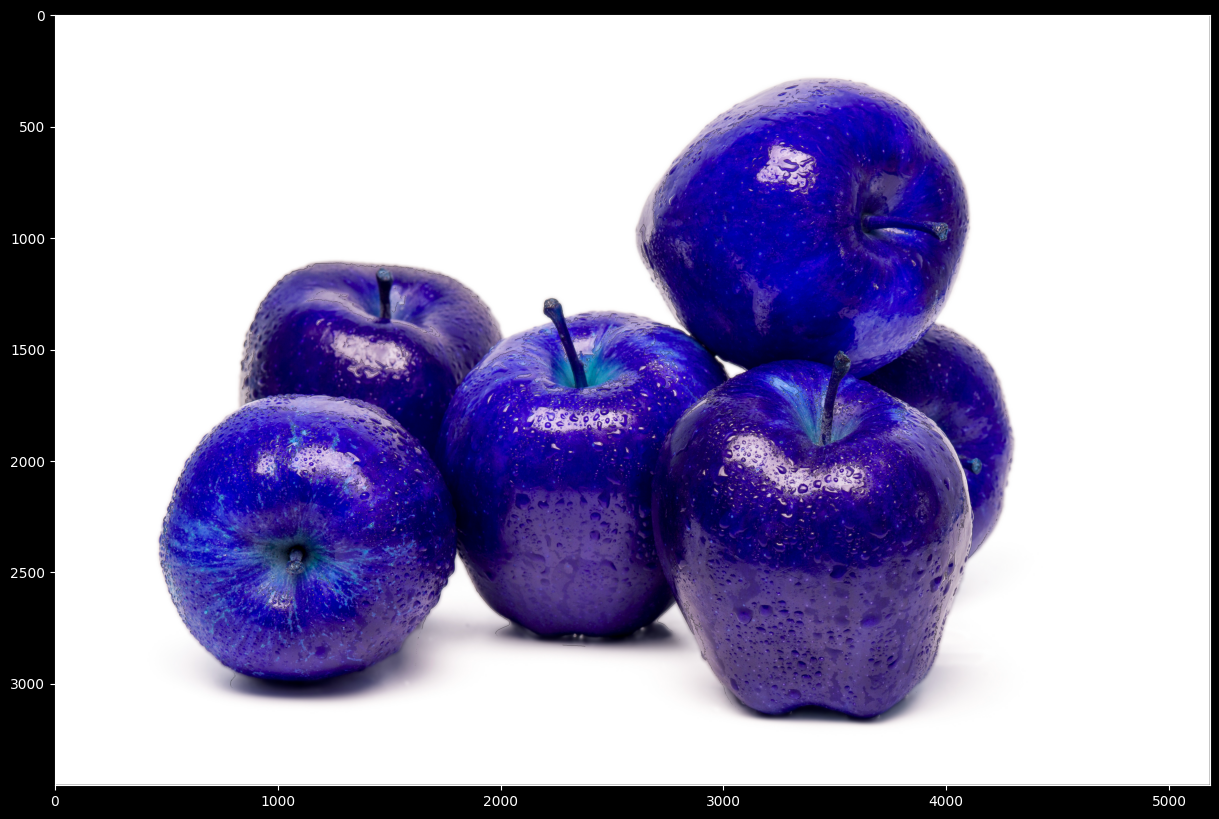

In [21]:
img_segmented = np.copy(img)
img_segmented[markers_ == -1] = [0,0,0]
plt.figure(figsize=(20,10))
plt.imshow(img_segmented);